# 06 Sourcing and Analyzing Time-Series Data

#### 1. Importing libraries and data
#### 2. Revewing Data and Wrangling
#### 3. Plotting Data 
#### 4. Time-series analysis: decomposition
#### 5. Smoothing and Reviewing Adjusted Decomposition
#### 6. Testing for Stationarity


# 1. Importing Libraries and Data

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [3]:
# cleaned flight data with all NaN values removed which inadvertantly removes all cancelled and diverted flights. Delays and other investigations can still be assessed
data = pd.read_csv('/Users/tuor/DA Projects/230523 Airline January 2023 Project/02 Data/Prepared Data/230616 2019 delayed with flight time.csv')

# 2. Revewing Data and Wrangling

In [5]:
pd.set_option('display.max_columns', None)

In [7]:
# removing secondary index column
data = data.drop(['Unnamed: 0'],axis=1)

In [8]:
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE,ORIGIN_CITY,ORIGIN_STATE_OR_REGION,ORIGIN_FULL_NAME,GMT_DEP,DEST_CITY,DEST_STATE_OR_REGION,DEST_FULL_NAME,GMT_ARR,dep_hour,arr_hour,flt_time_min,ORIGIN/DEST
0,1,2,9E,9E,N8688C,3280,GNV,ATL,601,0.0,0600-0659,722,0.0,300.0,Gainesville,FL,Florida,5,Atlanta,GA,Georgia,5,6,7,81.0,GNVATL
1,1,2,9E,9E,N348PQ,3281,MSP,CVG,1359,0.0,1400-1459,1633,0.0,596.0,Minneapolis,MN,Minnesota,6,Cincinnati,OH,Ohio,5,13,16,94.0,MSPCVG
2,1,2,9E,9E,N8896A,3282,DTW,CVG,1215,0.0,1200-1259,1329,0.0,229.0,Detroit,MI,Michigan,5,Cincinnati,OH,Ohio,5,12,13,74.0,DTWCVG
3,1,2,9E,9E,N8886A,3283,TLH,ATL,1521,0.0,1500-1559,1625,0.0,223.0,Tallahassee,FL,Florida,5,Atlanta,GA,Georgia,5,15,16,64.0,TLHATL
4,1,2,9E,9E,N8974C,3284,ATL,FSM,1847,0.0,1900-1959,1940,0.0,579.0,Atlanta,GA,Georgia,5,Fort Smith,AR,Arkansas,6,18,19,113.0,ATLFSM


In [16]:
# Create the new column 'GMT_ADJ_HR_DEP' using apply and lambda function. New column contains the departure time minus its GMT difference to baseline at GMT 0 for all values.
data['GMT_ADJ_HR_DEP'] = data.apply(lambda row: (row['dep_hour'] - row['GMT_DEP']) % 24, axis=1)


In [17]:
#reviewing results baselining to GMT 0
data['GMT_ADJ_HR_DEP'].value_counts()

4     38354
12    38254
1     38183
6     38082
2     38014
3     37738
10    36474
5     36173
8     35691
7     35281
11    35102
9     33671
0     31371
13    31126
14    27696
15    22181
23    18357
16    14604
22     9849
17     8428
21     4241
18     2211
19      757
20      723
Name: GMT_ADJ_HR_DEP, dtype: int64

In [21]:
#creating column for month
data['month'] = 1
data['year'] = 2021

In [24]:
# Combine the date components into a single string column
data['combined_datetime'] = data[['year', 'month', 'DAY_OF_MONTH', 'GMT_ADJ_HR_DEP']].astype(str).agg('-'.join, axis=1)

# Convert the 'combined_datetime' column to datetime format
data['time_series'] = pd.to_datetime(data['combined_datetime'], format='%Y-%m-%d-%H')

# Drop the temporary 'combined_datetime' column if not needed
data.drop(columns=['combined_datetime'], inplace=True)

In [25]:
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE,ORIGIN_CITY,ORIGIN_STATE_OR_REGION,ORIGIN_FULL_NAME,GMT_DEP,DEST_CITY,DEST_STATE_OR_REGION,DEST_FULL_NAME,GMT_ARR,dep_hour,arr_hour,flt_time_min,ORIGIN/DEST,GMT_ADJ_HR_DEP,month,year,time_series
0,1,2,9E,9E,N8688C,3280,GNV,ATL,601,0.0,0600-0659,722,0.0,300.0,Gainesville,FL,Florida,5,Atlanta,GA,Georgia,5,6,7,81.0,GNVATL,1,1,2021,2021-01-01 01:00:00
1,1,2,9E,9E,N348PQ,3281,MSP,CVG,1359,0.0,1400-1459,1633,0.0,596.0,Minneapolis,MN,Minnesota,6,Cincinnati,OH,Ohio,5,13,16,94.0,MSPCVG,7,1,2021,2021-01-01 07:00:00
2,1,2,9E,9E,N8896A,3282,DTW,CVG,1215,0.0,1200-1259,1329,0.0,229.0,Detroit,MI,Michigan,5,Cincinnati,OH,Ohio,5,12,13,74.0,DTWCVG,7,1,2021,2021-01-01 07:00:00
3,1,2,9E,9E,N8886A,3283,TLH,ATL,1521,0.0,1500-1559,1625,0.0,223.0,Tallahassee,FL,Florida,5,Atlanta,GA,Georgia,5,15,16,64.0,TLHATL,10,1,2021,2021-01-01 10:00:00
4,1,2,9E,9E,N8974C,3284,ATL,FSM,1847,0.0,1900-1959,1940,0.0,579.0,Atlanta,GA,Georgia,5,Fort Smith,AR,Arkansas,6,18,19,113.0,ATLFSM,13,1,2021,2021-01-01 13:00:00


In [26]:
#reviewing the data to see if there are enough same time series values to accomplish a time series analyzation
data['time_series'].value_counts()

2021-01-07 12:00:00    1430
2021-01-17 12:00:00    1416
2021-01-11 12:00:00    1410
2021-01-27 12:00:00    1391
2021-01-14 12:00:00    1387
                       ... 
2021-01-15 19:00:00       8
2021-01-14 19:00:00       8
2021-01-12 19:00:00       8
2021-01-16 19:00:00       7
2021-01-26 19:00:00       7
Name: time_series, Length: 744, dtype: int64

In [27]:
#creating data frame for time series analysis (tsa)
data_tsa = data[['time_series']]

In [29]:
data_tsa['number_of_flights'] = 1

In [34]:
data_tsa.head()

,time_series,number_of_flights
0,2021-01-01 00:00:00,823
1,2021-01-01 01:00:00,1116
2,2021-01-01 02:00:00,1081
3,2021-01-01 03:00:00,1177
4,2021-01-01 04:00:00,1186


In [31]:
# Group by 'time_series' and sum the 'number_of_flights'
data_tsa = data_tsa.groupby('time_series')['number_of_flights'].sum().reset_index()

In [37]:
data_tsa.info

<bound method DataFrame.info of             time_series  number_of_flights
0   2021-01-01 00:00:00                823
1   2021-01-01 01:00:00               1116
2   2021-01-01 02:00:00               1081
3   2021-01-01 03:00:00               1177
4   2021-01-01 04:00:00               1186
..                  ...                ...
739 2021-01-31 19:00:00                 25
740 2021-01-31 20:00:00                 28
741 2021-01-31 21:00:00                153
742 2021-01-31 22:00:00                316
743 2021-01-31 23:00:00                502

[744 rows x 2 columns]>

In [40]:
# Sort the DataFrame by 'time_series' and set it as the index
data_tsa = data_tsa.sort_values(by='time_series').set_index('time_series')

In [41]:
data_tsa.head()

,number_of_flights
time_series,
2021-01-01 00:00:00,823
2021-01-01 01:00:00,1116
2021-01-01 02:00:00,1081
2021-01-01 03:00:00,1177
2021-01-01 04:00:00,1186


# 3. Plotting Data 

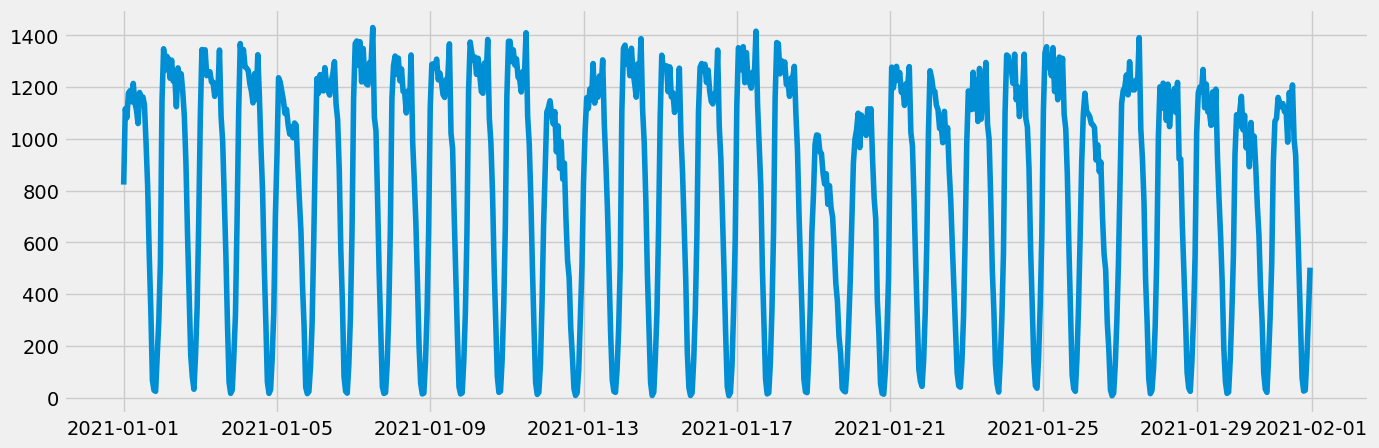

In [42]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_tsa)

# 4. Time-series analysis: decomposition

In [44]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_tsa, model='additive')

In [45]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

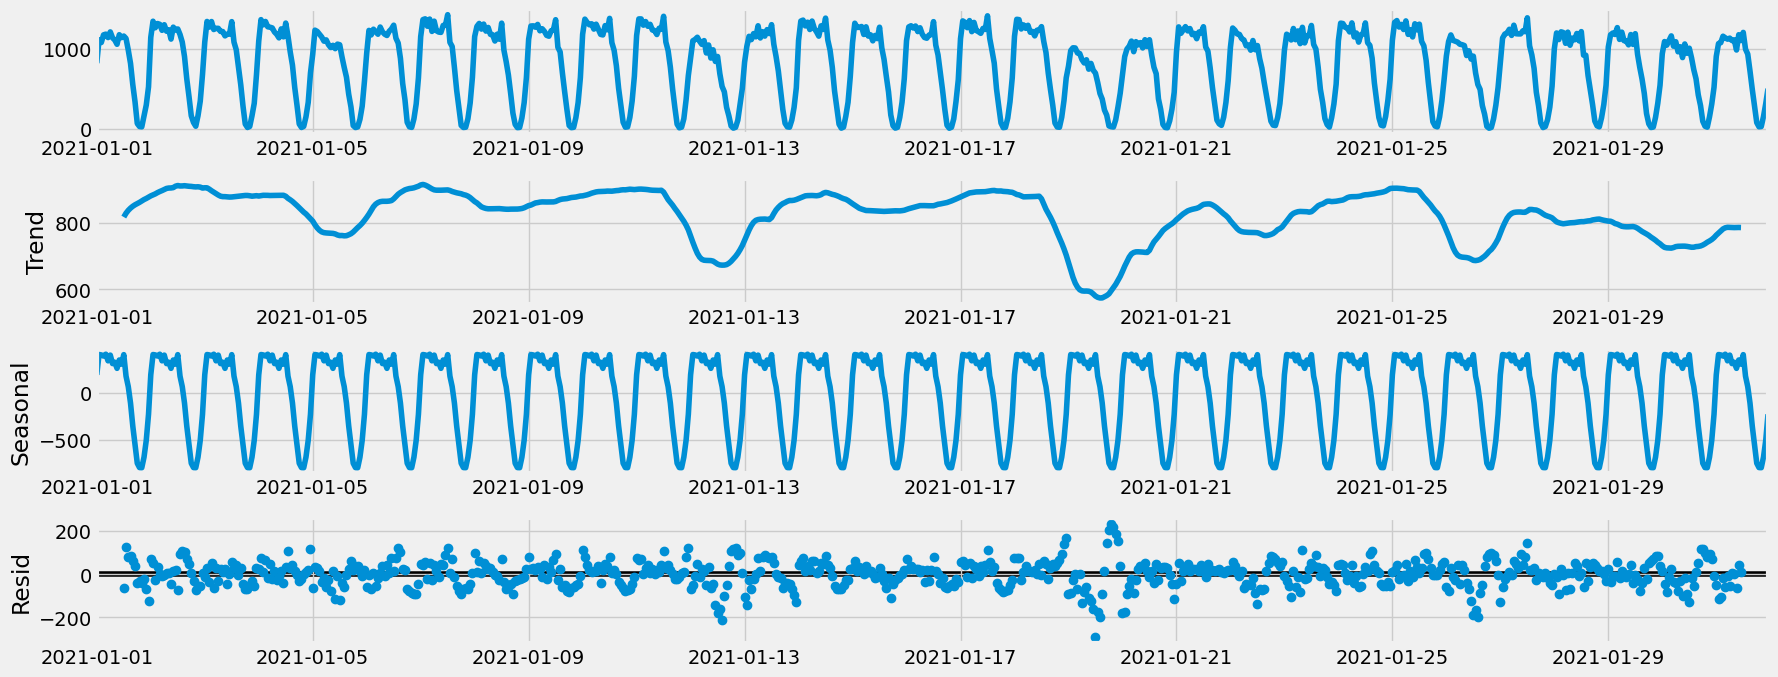

In [46]:
# Plot the separate components

decomposition.plot()
plt.show()

# 5. Smoothing and Reviewing Adjusted Decomposition

In [93]:
# Apply smoothing using a moving average with a window size of 24
window_size = 24
data_tsa_smoothed = data_tsa['number_of_flights'].rolling(window=window_size, min_periods=1).mean()


In [102]:
data_tsa_smoothed.head()

,number_of_flights
time_series,
2021-01-01 00:00:00,823.000000
2021-01-01 01:00:00,969.500000
2021-01-01 02:00:00,1006.666667
2021-01-01 03:00:00,1049.250000
2021-01-01 04:00:00,1076.600000


In [101]:
data_tsa_smoothed = data_tsa_smoothed.to_frame()


In [103]:
# Decompose the time series using an additive model

decomposition_smoothed = sm.tsa.seasonal_decompose(data_tsa_smoothed, model='additive')

In [104]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

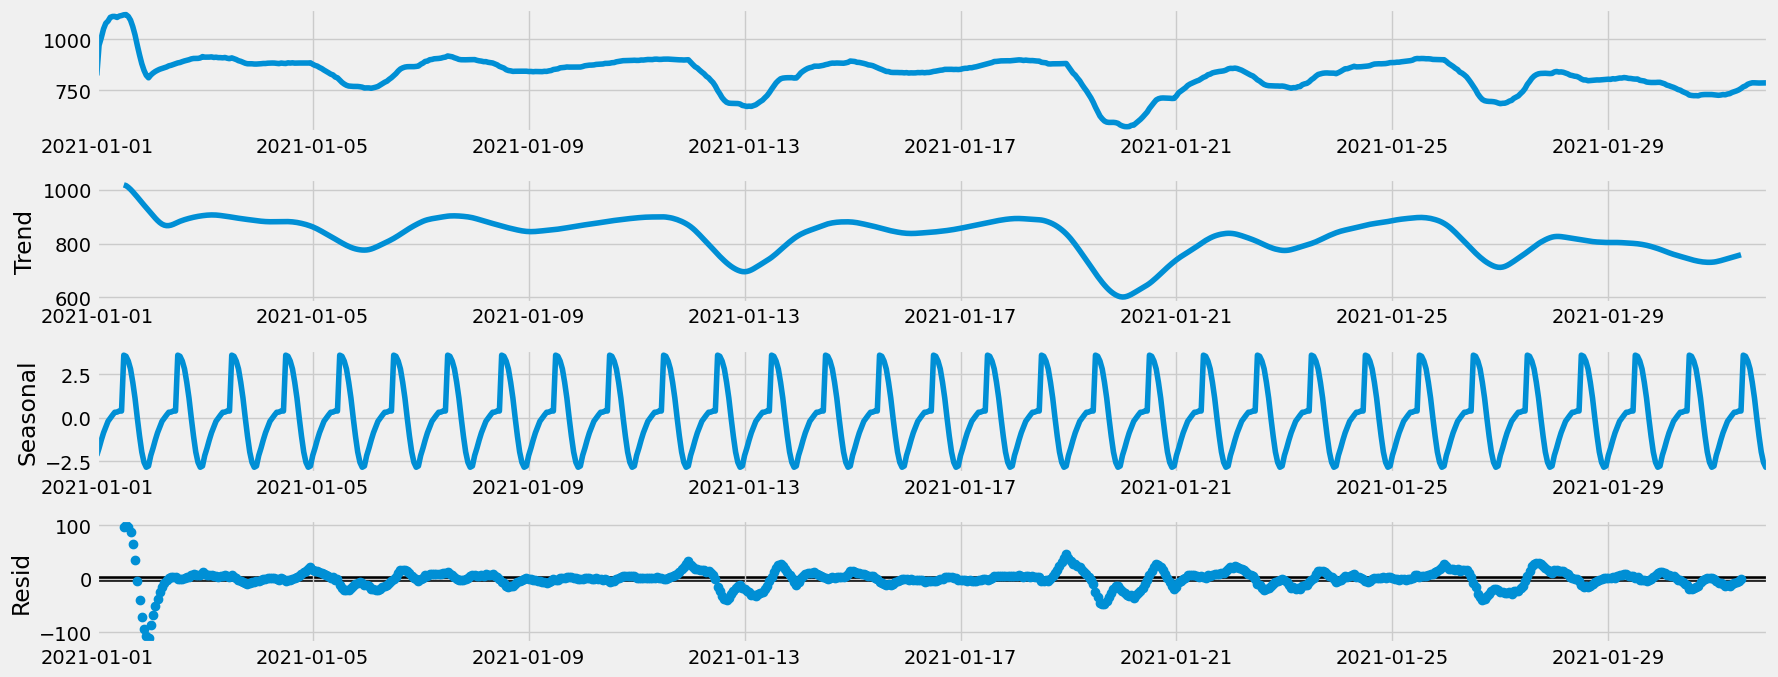

In [105]:
# Plot the separate components

decomposition_smoothed.plot()
plt.show()

# 6. Testing for Stationarity

In [106]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.


from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_tsa_smoothed['number_of_flights'])

Dickey-Fuller Stationarity test:
Test Statistic                  -4.002092
p-value                          0.001400
Number of Lags Used             19.000000
Number of Observations Used    724.000000
Critical Value (1%)             -3.439414
Critical Value (5%)             -2.865540
Critical Value (10%)            -2.568900
dtype: float64


Dickey fuller test says stationary as 5% confidence number is greater than the Test statistic and the p value is less than .05

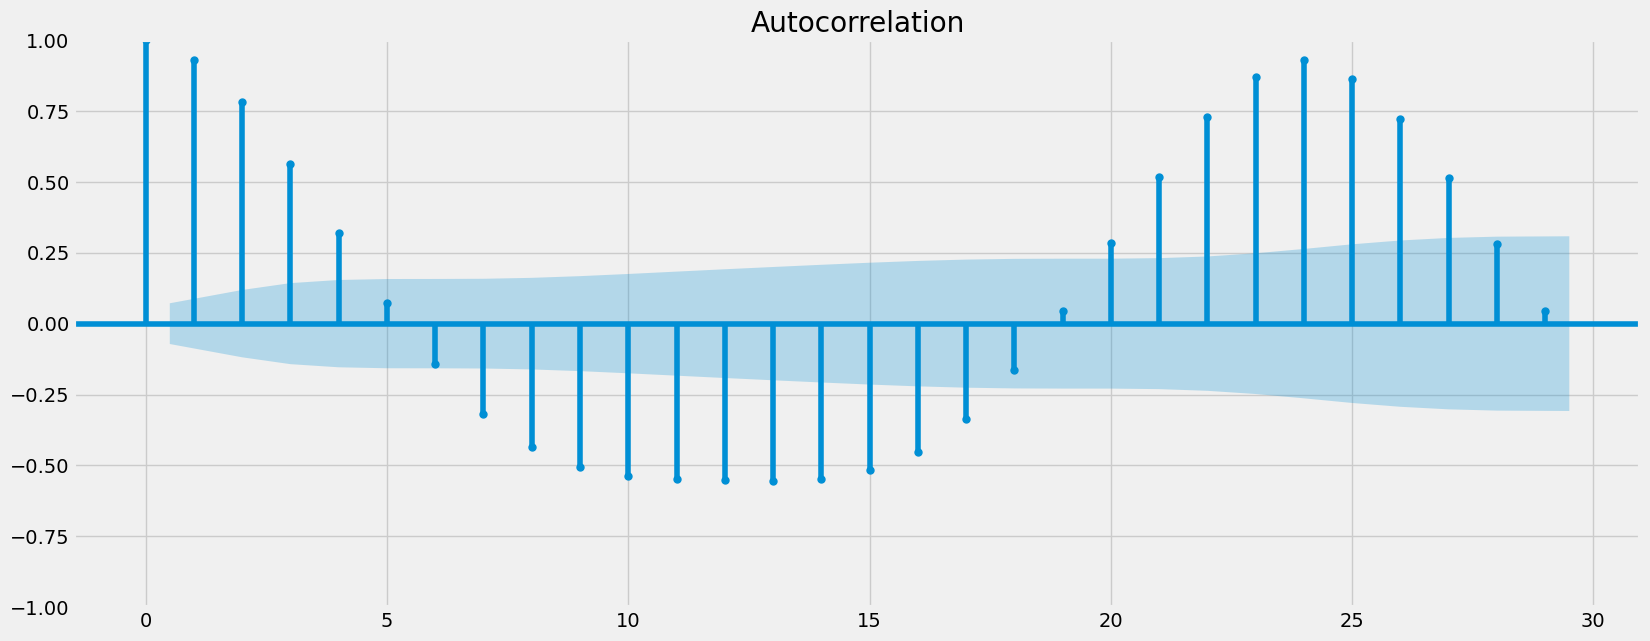

In [107]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_tsa)
plt.show()

To many lags outside of the blue highlight indicating non stationarity so differencing to make data stationary

In [108]:
data_diff = data_tsa_smoothed - data_tsa_smoothed.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [109]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [110]:
data_diff.head()

,number_of_flights
time_series,
2021-01-01 01:00:00,146.500000
2021-01-01 02:00:00,37.166667
2021-01-01 03:00:00,42.583333
2021-01-01 04:00:00,27.350000
2021-01-01 05:00:00,11.066667


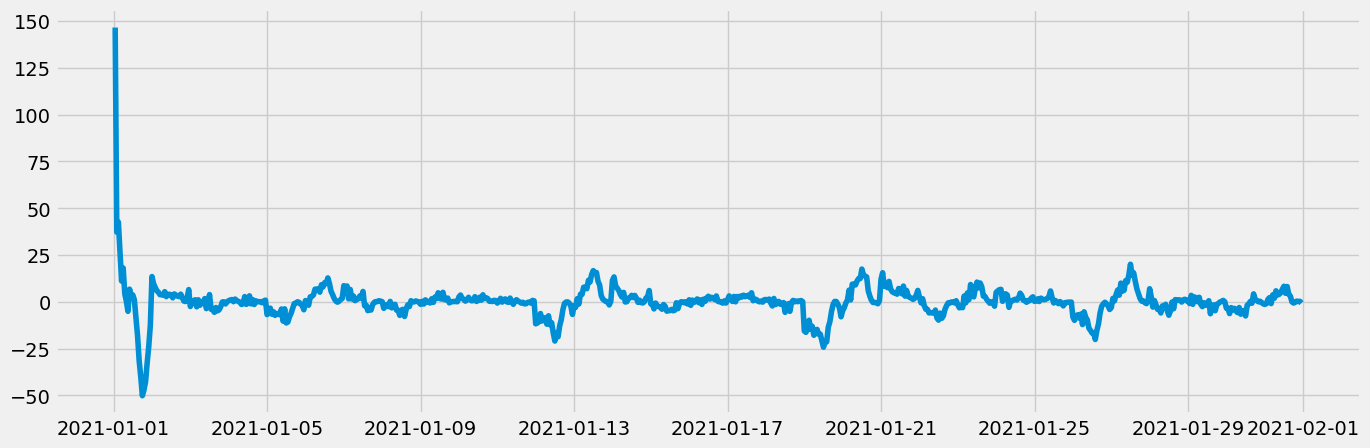

In [111]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [112]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.370471e+00
p-value                        2.351936e-08
Number of Lags Used            2.000000e+01
Number of Observations Used    7.220000e+02
Critical Value (1%)           -3.439440e+00
Critical Value (5%)           -2.865551e+00
Critical Value (10%)          -2.568906e+00
dtype: float64


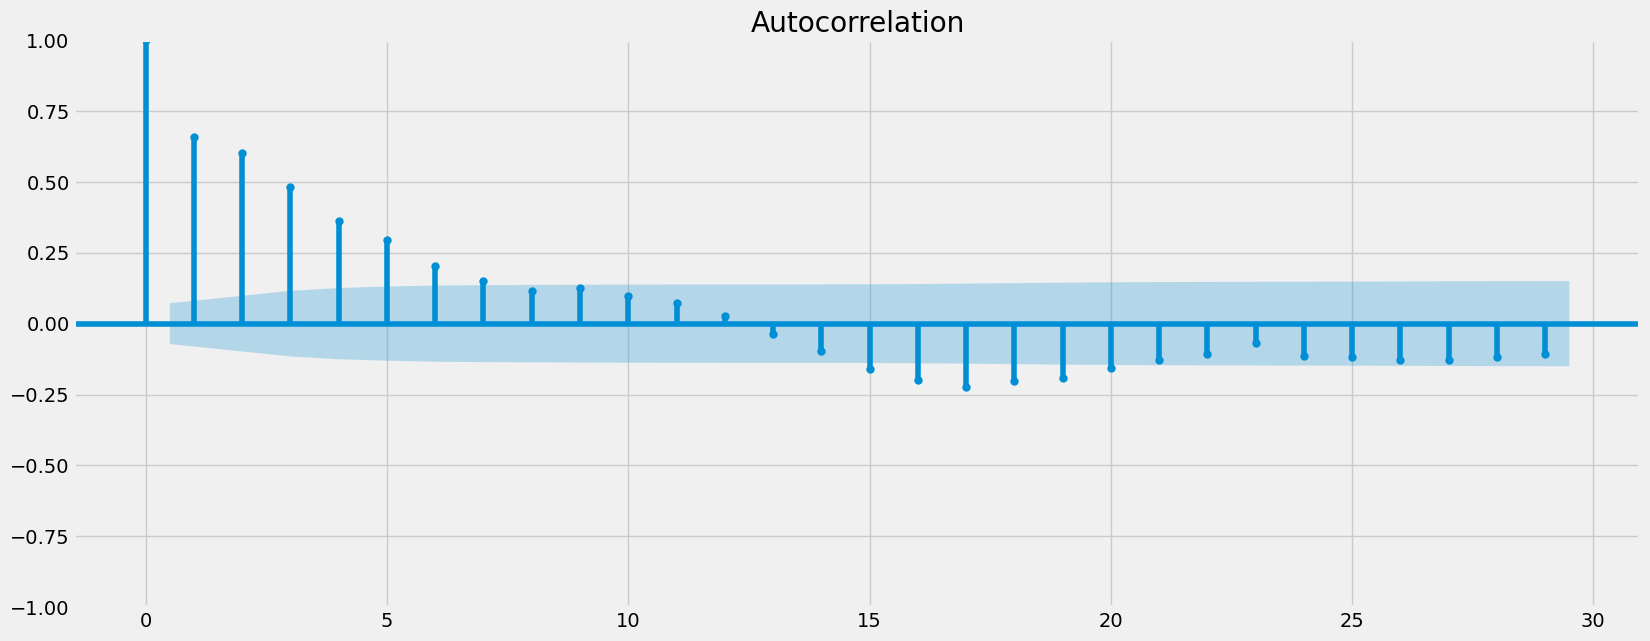

In [113]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots


plot_acf(data_diff)
plt.show()

Roughly Stationary. There are still a number of lags uncovered, but close to 10. The dickey_fuller test is also clearly showing it is stationary with the 5% Critical value far greater than the Test Statistic. The p-value is also sub .05. All said this indicates the null hypothesis of a unit root is false which indicates stationary data.